In [6]:
import os
os.chdir('D:/Sohum/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime
import calendar
import plotly
from plotly import *
import osmnx as ox

#### In this notebook we will try to understand how different factors lead to Accidents

A lot of data exploration will be done in this notebook along with understanding correlation between different factors leading to accidents

In [7]:
file = 'us_acc.csv'

In [8]:
pd.read_csv(file).columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

We cannot load all the data into the RAM. A lot of these collumns do not seem to have any relation with the accidents. Hence we will use only the below mentioned columns

In [9]:
df = pd.read_csv(file,
usecols = ['Source', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'City','State','Temperature(F)',
       'Visibility(mi)','Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition'])

We will try to understand what these factors represent
1.  Source: From where the information about accident was uncovered.
2.  Severity: On a scale of 1 to 4, 4 being the most deadly accident.
3. Start time and end time of the accident.
4. Start lang and lat define the longitude and latitude of the accident that took place.
5. City and state define the locations of the accident.
6. Temperature in farhenheit
7. Visibility in miles
8. Wind speed in miles per hour.
9. Precipitation in inches.
10. Weather condition defined by a string

In [17]:
print(df.shape)
df.head()

(3513617, 13)


,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,State,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition
0,MapQuest,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,Dayton,OH,36.9,10.0,NaN,0.02,Light Rain
1,MapQuest,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,Reynoldsburg,OH,37.9,10.0,NaN,0.00,Light Rain
2,MapQuest,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,Williamsburg,OH,36.0,10.0,3.5,NaN,Overcast
3,MapQuest,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,Dayton,OH,35.1,9.0,4.6,NaN,Mostly Cloudy
4,MapQuest,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,Dayton,OH,36.0,6.0,3.5,NaN,Mostly Cloudy


In [49]:
df.isna().sum()/df.shape[0]*100

Source                0.000000
Severity              0.000000
Start_Time            0.000000
End_Time              0.000000
Start_Lat             0.000000
Start_Lng             0.000000
City                  0.003188
State                 0.000000
Temperature(F)        1.870779
Visibility(mi)        2.158915
Wind_Speed(mph)      12.938490
Precipitation(in)    57.657793
Weather_Condition     2.166941
dtype: float64

Over 57% of the precipitation data is NaN values. Hence there is no point in interpolating those values or filling the mean of the given values. We will drop the column of precipitation

Since we have ample of data, we will drop the rows which have a NAN value

In [50]:
df = df.drop(columns=['Precipitation(in)'])

In [51]:
df = df.fillna(method='bfill')

In [59]:
a = df['Start_Time']
b = df['End_Time']
a = pd.to_datetime(a)
b = pd.to_datetime(b)
df['Road_block_time(min)'] = (b - a)/np.timedelta64(1,'m')
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
#This will give us the time for which the road was blocked in minutes

In [60]:
df.head()

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,State,Temperature(F),Visibility(mi),Wind_Speed(mph),Weather_Condition,Road_block_time(min)
0,MapQuest,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,Dayton,OH,36.9,10.0,3.5,Light Rain,314.0
1,MapQuest,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,Reynoldsburg,OH,37.9,10.0,3.5,Light Rain,30.0
2,MapQuest,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,Williamsburg,OH,36.0,10.0,3.5,Overcast,30.0
3,MapQuest,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,Dayton,OH,35.1,9.0,4.6,Mostly Cloudy,30.0
4,MapQuest,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,Dayton,OH,36.0,6.0,3.5,Mostly Cloudy,30.0


In [64]:
df['Year'] = pd.DatetimeIndex(df.Start_Time).year

In [91]:
df.head()

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,State,Temperature(F),Visibility(mi),Wind_Speed(mph),Weather_Condition,Road_block_time(min),Year
0,MapQuest,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,Dayton,OH,36.9,10.0,3.5,Light Rain,314.0,2016
1,MapQuest,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,Reynoldsburg,OH,37.9,10.0,3.5,Light Rain,30.0,2016
2,MapQuest,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,Williamsburg,OH,36.0,10.0,3.5,Overcast,30.0,2016
3,MapQuest,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,Dayton,OH,35.1,9.0,4.6,Mostly Cloudy,30.0,2016
4,MapQuest,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,Dayton,OH,36.0,6.0,3.5,Mostly Cloudy,30.0,2016


There is a lot of data in this file. Making sense of it will only be possible if we are able to divide the data into different time frames.

In [66]:
df_16 = df[df.Year == 2016]
df_16 = df_16.sort_values(by=['Start_Time'])
df_16 = df_16.reset_index(drop=True)

df_17 = df[df.Year == 2017]
df_17 = df_17.sort_values(by=['Start_Time'])
df_17 = df_17.reset_index(drop=True)

df_18 = df[df.Year == 2018]
df_18 = df_18.sort_values(by=['Start_Time'])
df_18 = df_18.reset_index(drop=True)

df_19 = df[df.Year == 2019]
df_19 = df_19.sort_values(by=['Start_Time'])
df_19 = df_19.reset_index(drop=True)

df_20 = df[df.Year == 2020]
df_20 = df_20.sort_values(by=['Start_Time'])
df_20 = df_20.reset_index(drop=True)


We now have seperated data for all the different years

## Let us start working for the year 2016

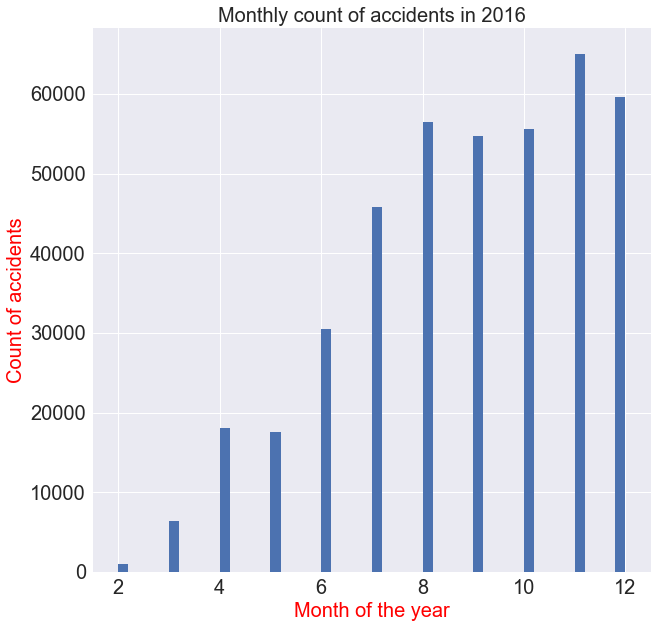

In [77]:
fig = plt.figure(figsize = (10,10))
plt.hist(pd.DatetimeIndex(df_16.Start_Time).month,bins=50)
plt.xlabel("Month of the year",fontsize=20,c='r')
plt.ylabel("Count of accidents",fontsize=20,c='r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)     
plt.title("Monthly count of accidents in 2016",fontsize=20)
plt.show()

Maximum number of accidents are to be observed in the month of November and December

We have to observe what factors can play a role in the time for which a road is closed after an accident

Need less to say, the accidents with severity 3/4 will result in the road being closed for a longer period of time.

In this study, we will only consider the accident which caused a road blockage for less than or equal to one week. Any road being blocked for more than one week can be considered an outlier

In [78]:
df_16 = df_16[df_16['Road_block_time(min)'] < 10080]

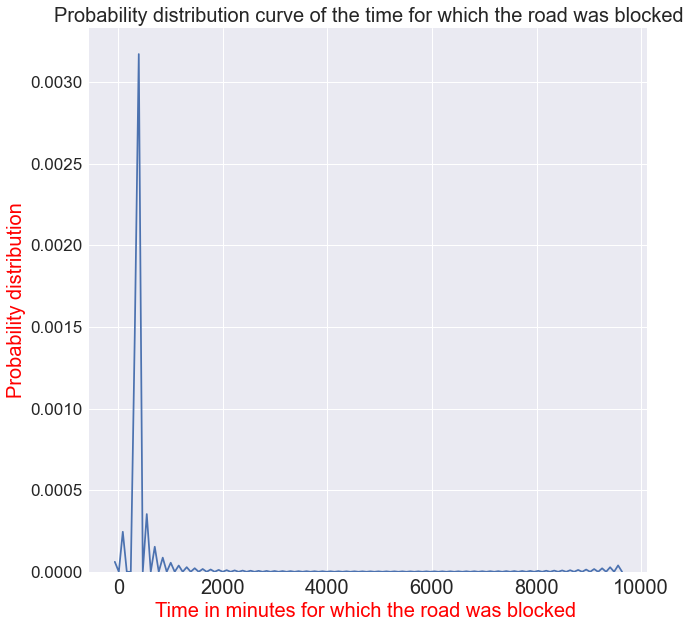

In [82]:
fig = plt.figure(figsize = (10,10))
sns.distplot(df_16['Road_block_time(min)'],hist=False)
plt.xlabel("Time in minutes for which the road was blocked ",fontsize=20,c='r')
plt.ylabel("Probability distribution",fontsize=20,c='r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=17)     
plt.title("Probability distribution curve of the time for which the road was blocked",fontsize=20)
plt.show()

We can observe that majority of the values lie between 0-900 minutes i.e 15 hours

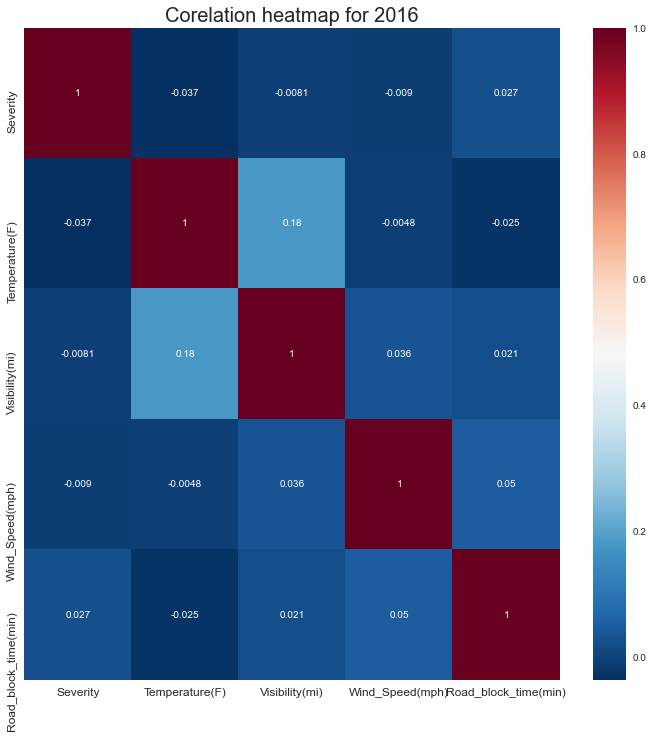

In [89]:
fig = plt.figure(figsize = (12,12))
sns.heatmap(df_16[['Severity','Temperature(F)','Visibility(mi)',
                   'Wind_Speed(mph)','Road_block_time(min)']].corr(),
            cmap='RdBu_r',annot=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Corelation heatmap for 2016",fontsize=20)
plt.show()

The features above are faintly related to the road block time as can be seen from the above heatmap 

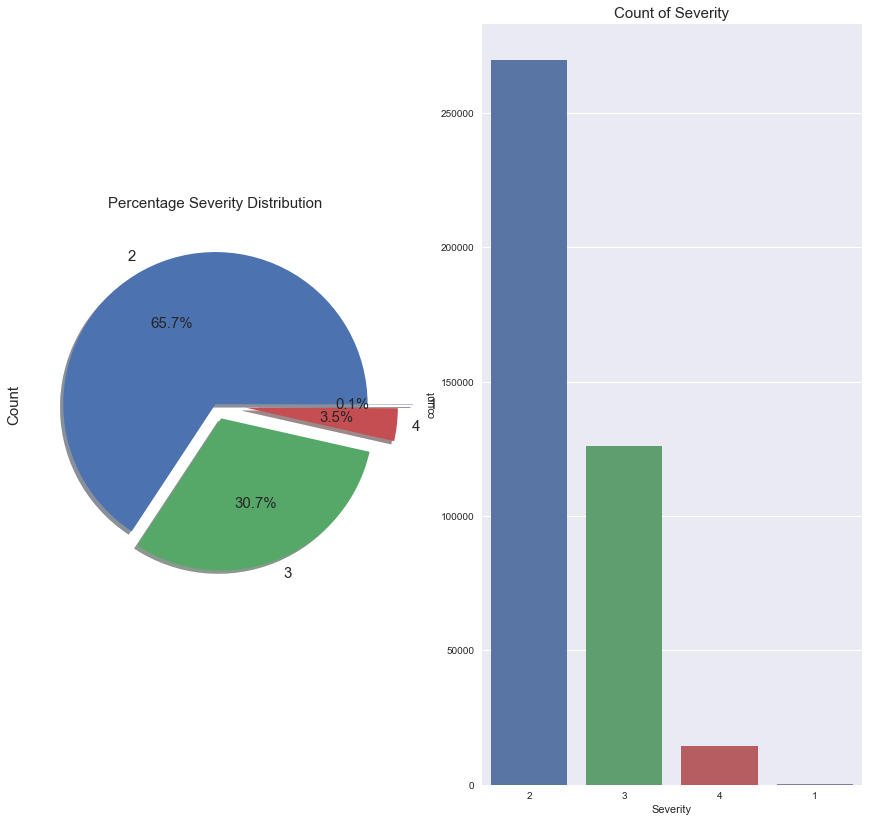

In [97]:
f,ax=plt.subplots(1,2,figsize=(15,14))
df_16['Severity'].value_counts().plot.pie(explode=[0,0.1,0.2,0.3],
                                       autopct='%1.1f%%',ax=ax[0],shadow=True,fontsize=15)
ax[0].set_title('Percentage Severity Distribution',fontsize=15)
ax[0].set_ylabel('Count',fontsize=15)
sns.countplot('Severity',data=df_16,ax=ax[1],order=df_16['Severity'].value_counts().index)
ax[1].set_title('Count of Severity',fontsize=15)
plt.show()

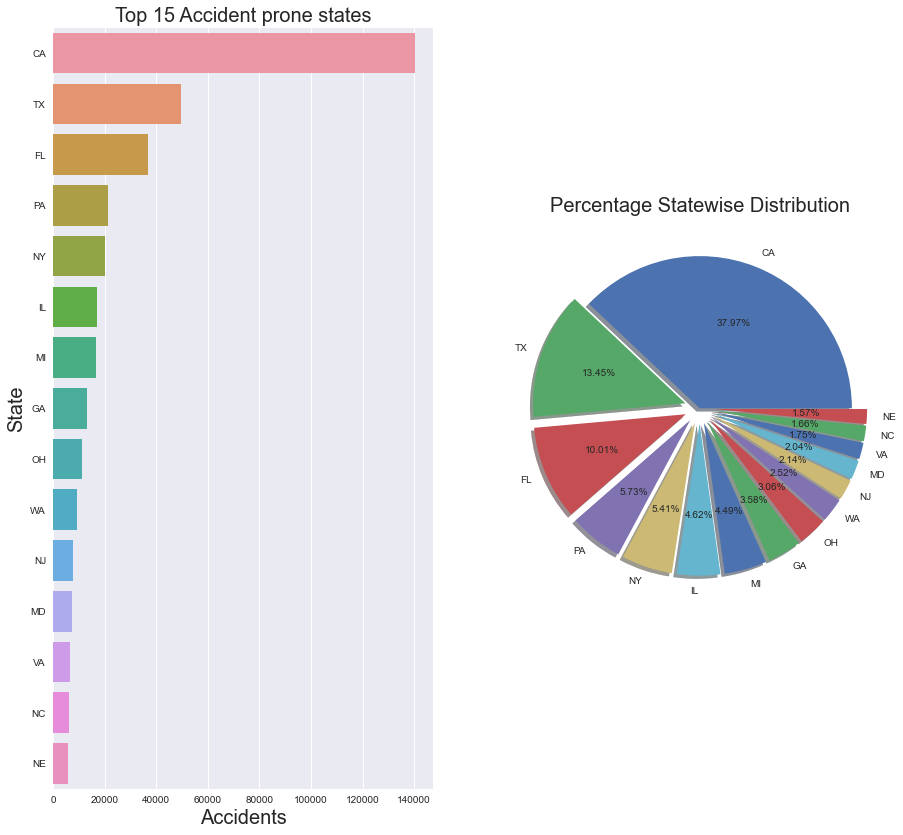

In [18]:
data = df_16.State.value_counts().reset_index().rename(columns={
    'index':'State',
    'State' : 'accidents'
}).head(15)
f,ax = plt.subplots(1,2,figsize=(15,14))
sns.barplot(x = 'accidents',y = 'State',data=data,ax=ax[0])
ax[0].set_title("Top 15 Accident prone states",fontsize=20)
ax[0].set_xlabel("Accidents",fontsize=20)
ax[0].set_ylabel("State",fontsize=20)
lst = [0.1]*15
lst[0] = 0
plt.pie(data.accidents,labels=data.State,shadow=True,autopct='%1.2f%%',explode=lst)
ax[1].set_title('Percentage Statewise Distribution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [20]:
np.unique(df_16.Weather_Condition)

array(['Blowing Dust', 'Blowing Dust / Windy', 'Blowing Sand',
       'Blowing Snow', 'Clear', 'Cloudy', 'Cloudy / Windy', 'Drizzle',
       'Fair', 'Fair / Windy', 'Fog', 'Funnel Cloud', 'Hail', 'Haze',
       'Heavy Drizzle', 'Heavy Rain', 'Heavy Snow', 'Heavy T-Storm',
       'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Rain',
       'Heavy Thunderstorms and Snow', 'Light Drizzle', 'Light Fog',
       'Light Freezing Drizzle', 'Light Freezing Fog',
       'Light Freezing Rain', 'Light Ice Pellets', 'Light Rain',
       'Light Rain / Windy', 'Light Rain Showers',
       'Light Rain with Thunder', 'Light Snow', 'Light Snow Showers',
       'Light Thunderstorms and Rain', 'Light Thunderstorms and Snow',
       'Low Drifting Snow', 'Mist', 'Mostly Cloudy',
       'Mostly Cloudy / Windy', 'N/A Precipitation', 'Overcast',
       'Partly Cloudy', 'Partly Cloudy / Windy', 'Patches of Fog', 'Rain',
       'Rain / Windy', 'Rain Showers', 'Sand', 'Scattered Clouds',
       'Shallow Fog', 

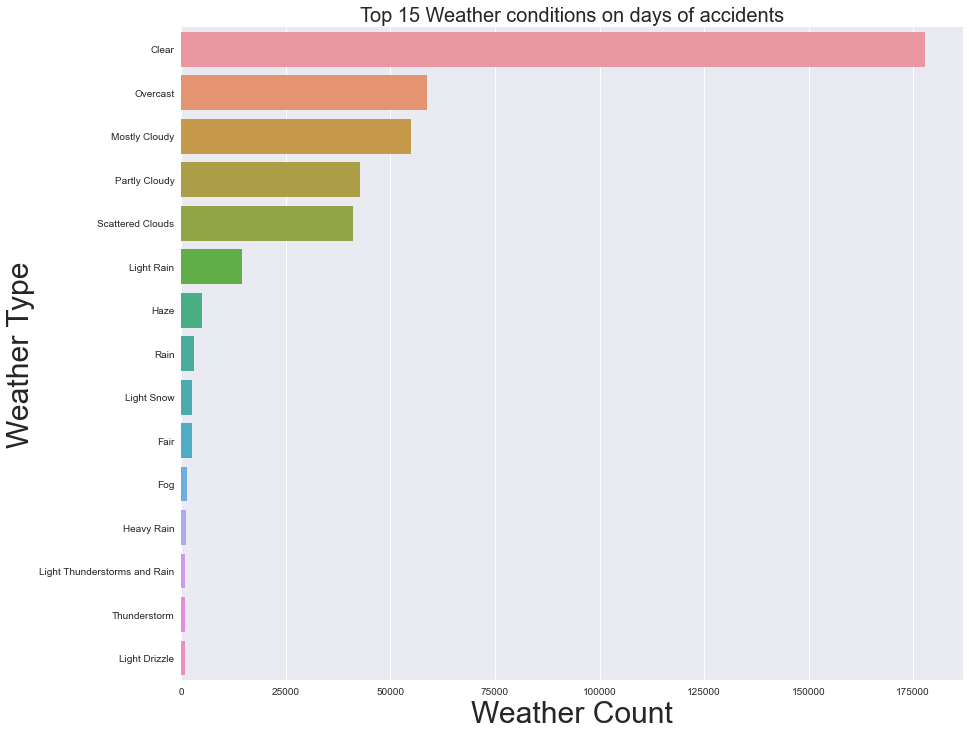

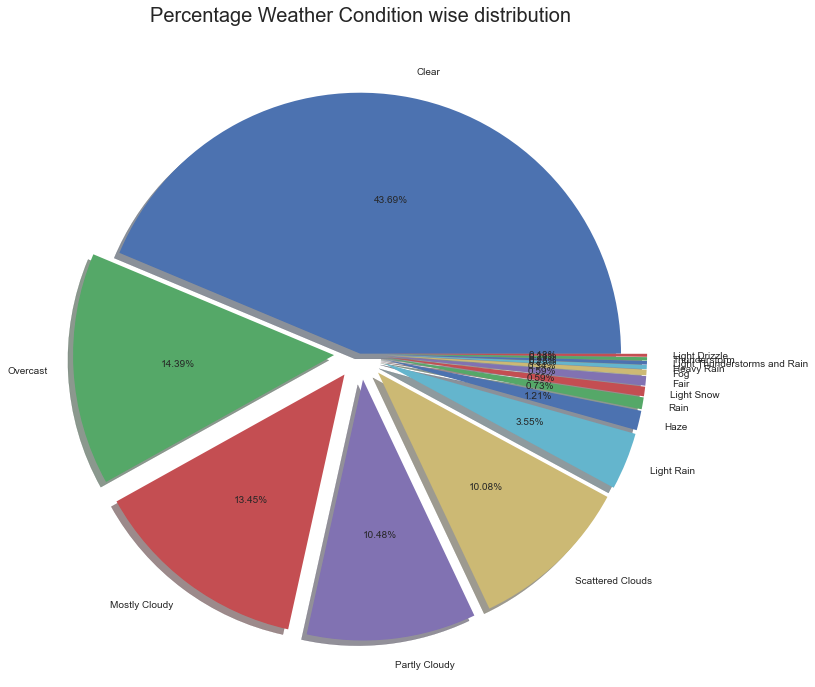

In [21]:
data_weath = df_16.Weather_Condition.value_counts().reset_index().rename(columns={
    'index':'Weather_Condition',
    'Weather_Condition' : 'Weather_Counts'
}).head(15)
fig = plt.figure(figsize=(14,12))
sns.barplot(x = 'Weather_Counts',y = 'Weather_Condition',data=data_weath)
plt.title("Top 15 Weather conditions on days of accidents",fontsize=20)
plt.xlabel("Weather Count",fontsize=30)
plt.ylabel("Weather Type",fontsize=30)
plt.show()
lst = [0.1]*15
lst[0] = 0
fig = plt.figure(figsize=(14,12))
plt.pie(data_weath.Weather_Counts,labels=data_weath.Weather_Condition,
        shadow=True,autopct='%1.2f%%',explode=lst)
plt.title('Percentage Weather Condition wise distribution',fontsize=20)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.show()

Almost 44% of the total accidents that took place in 2016 took place when the weather was Clear. Hence, accidental probability cannot be pinned on the weather status. The maximum that can be deduced is the fact that overcast and cloudy weather does constitute close to 49% of the total accidents. Hence Light rains and cloudy weather can be pinned to cause accidents

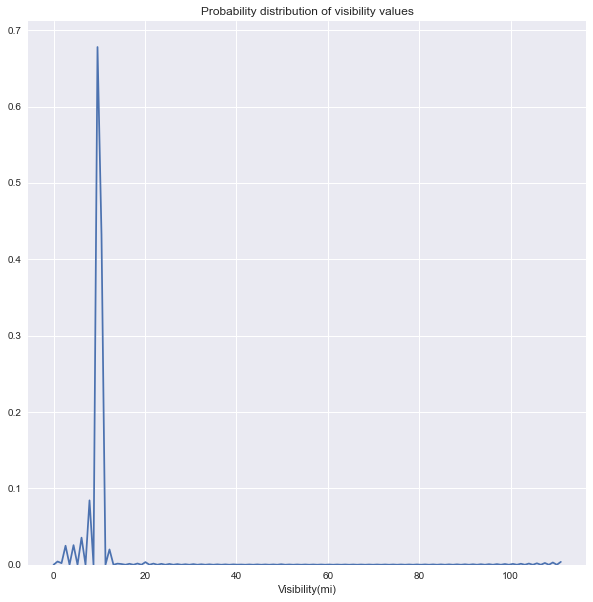

In [99]:
fig = plt.figure(figsize=(10,10))
sns.distplot(df_16['Visibility(mi)'],hist=False)
plt.title("Probability distribution of visibility values")
plt.show()

For a normal object which is not humongous in size, the 10 mile notation is used to define a clear day in terms of visibility. When visibility is defined as 10 miles, it is referred that there are no clouds at all and visibility is maximum. Any values that exceed the 10 miles mark constitute as an outlier. Hence they need to be removed.

In [23]:
df_vis = df_16[df_16['Visibility(mi)'] <= 10 ]

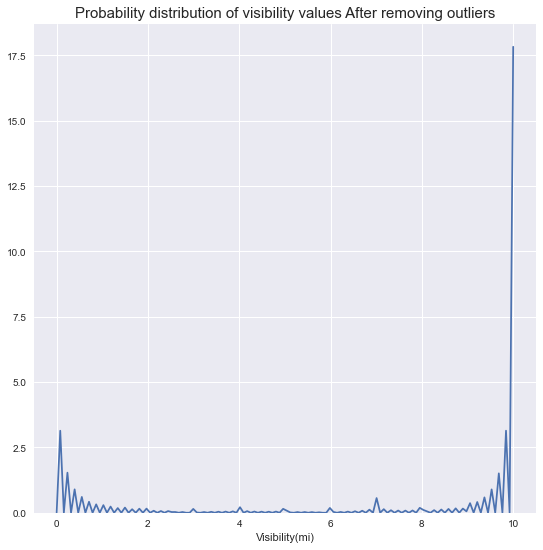

In [24]:
fig = plt.figure(figsize=(9,9))
sns.distplot(df_vis['Visibility(mi)'],hist=False)
plt.title("Probability distribution of visibility values After removing outliers",
         fontsize=15)
plt.show()

A spike can be seen around the region of visibility less than 1 mile. Hence it can be said that low visibility can be an acceptable reason for the occurence of an accident. But, nevertheless, majority of the accidents that occured were on the days of full visibility and clear weather.

That is why the Co-relation heatmap could not define any major co-relation between the visibility and weather. Majority of accidents in 2016 can be blamed as the driver's/rider's fault and not the weather's.

## Now we will copy all the above code and derive similar statistics for the following years

#### 2017

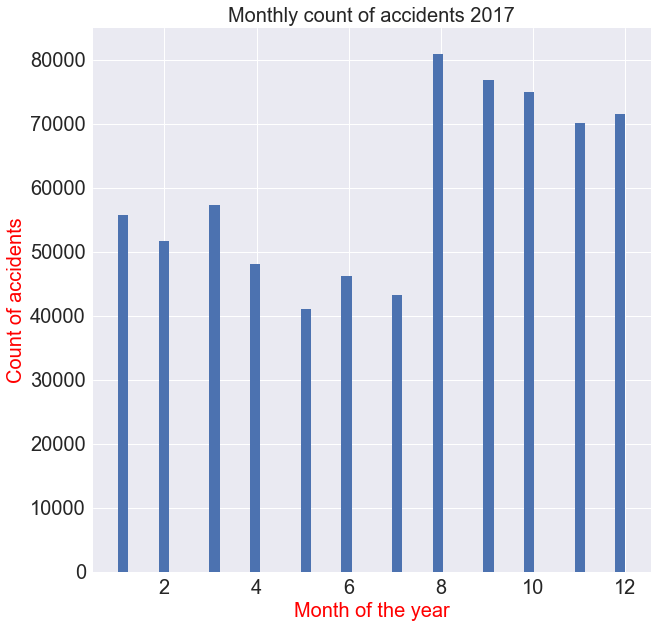

In [38]:
fig = plt.figure(figsize = (10,10))
plt.hist(pd.DatetimeIndex(df_17.Start_Time).month,bins=50)
plt.xlabel("Month of the year",fontsize=20,c='r')
plt.ylabel("Count of accidents",fontsize=20,c='r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)     
plt.title("Monthly count of accidents 2017",fontsize=20)
plt.show()

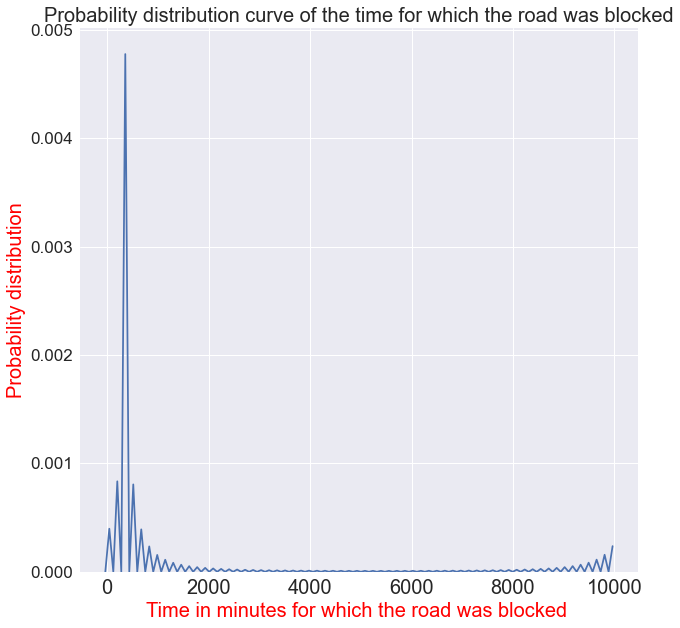

In [39]:
df_17 = df_17[df_17['Road_block_time(min)'] < 10080]
fig = plt.figure(figsize = (10,10))
sns.distplot(df_17['Road_block_time(min)'],hist=False)
plt.xlabel("Time in minutes for which the road was blocked ",fontsize=20,c='r')
plt.ylabel("Probability distribution",fontsize=20,c='r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=17)     
plt.title("Probability distribution curve of the time for which the road was blocked",fontsize=20)
plt.show()

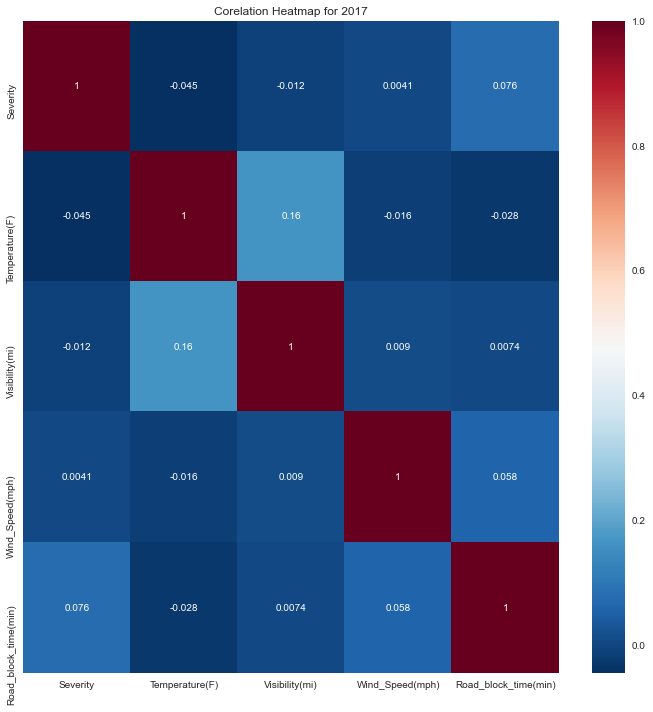

In [41]:
fig = plt.figure(figsize = (12,12))
sns.heatmap(df_17[['Severity','Temperature(F)','Visibility(mi)',
                   'Wind_Speed(mph)','Road_block_time(min)']].corr(),
            cmap='RdBu_r',annot=True)
plt.title("Corelation Heatmap for 2017")
plt.show()

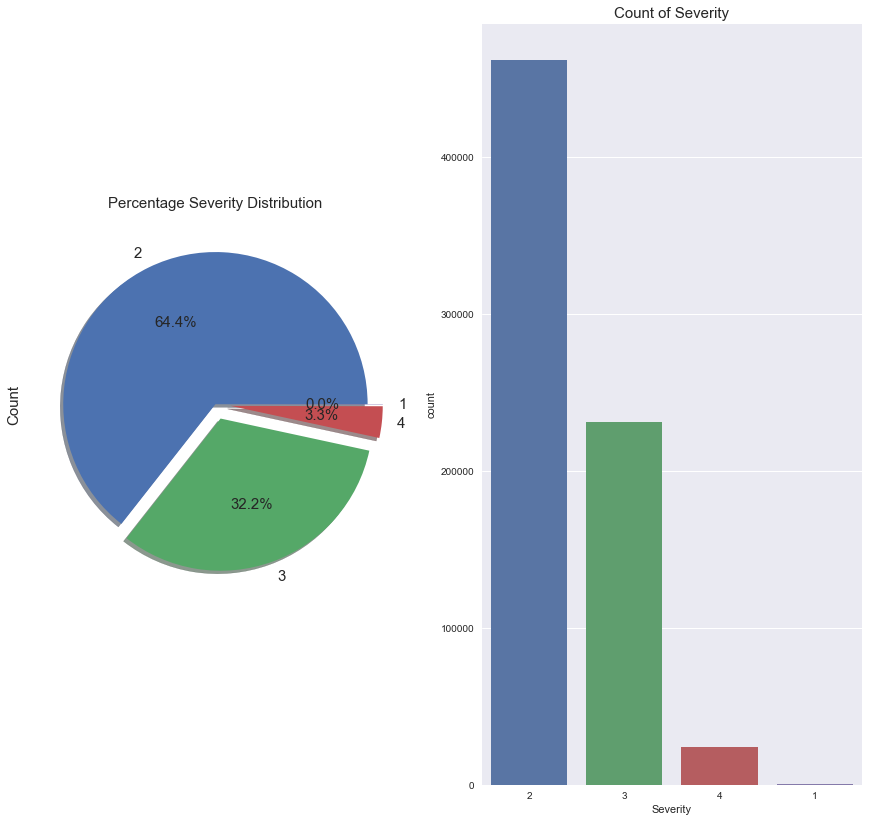

In [43]:
f,ax=plt.subplots(1,2,figsize=(15,14))
df_17['Severity'].value_counts().plot.pie(explode=[0,0.1,0.1,0.1],
                                       autopct='%1.1f%%',ax=ax[0],shadow=True,fontsize=15)
ax[0].set_title('Percentage Severity Distribution',fontsize=15)
ax[0].set_ylabel('Count',fontsize=15)
sns.countplot('Severity',data=df_17,ax=ax[1],order=df_17['Severity'].value_counts().index)
ax[1].set_title('Count of Severity',fontsize=15)
plt.show()

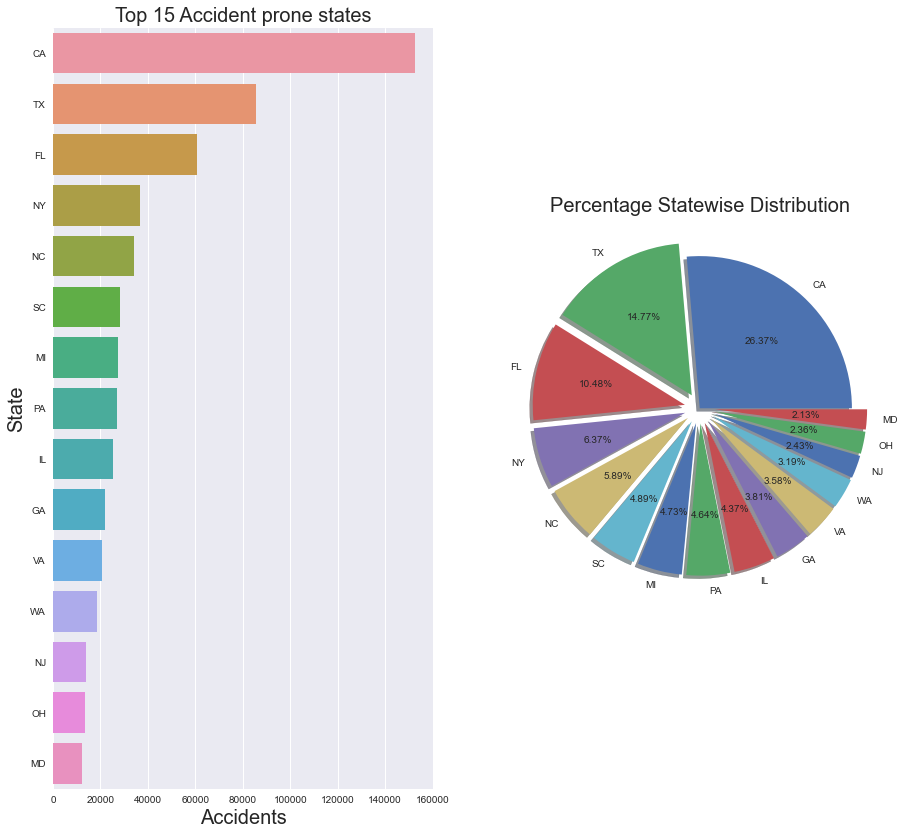

In [44]:
data = df_17.State.value_counts().reset_index().rename(columns={
    'index':'State',
    'State' : 'accidents'
}).head(15)
f,ax = plt.subplots(1,2,figsize=(15,14))
sns.barplot(x = 'accidents',y = 'State',data=data,ax=ax[0])
ax[0].set_title("Top 15 Accident prone states",fontsize=20)
ax[0].set_xlabel("Accidents",fontsize=20)
ax[0].set_ylabel("State",fontsize=20)
lst = [0.1]*15
lst[0] = 0
plt.pie(data.accidents,labels=data.State,shadow=True,autopct='%1.2f%%',explode=lst)
ax[1].set_title('Percentage Statewise Distribution',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

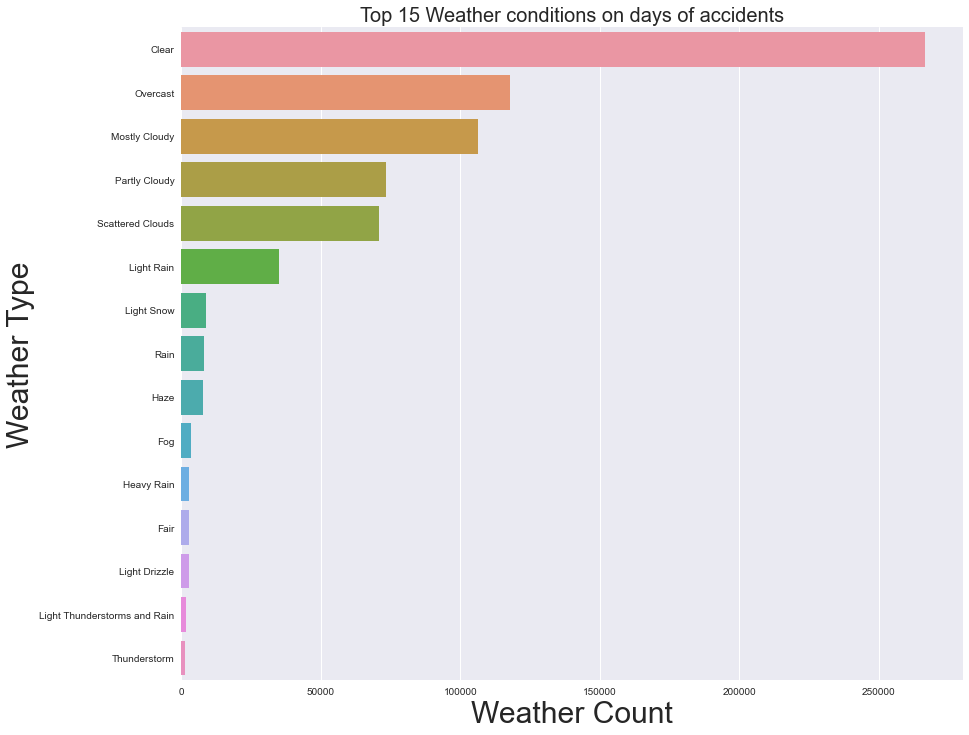

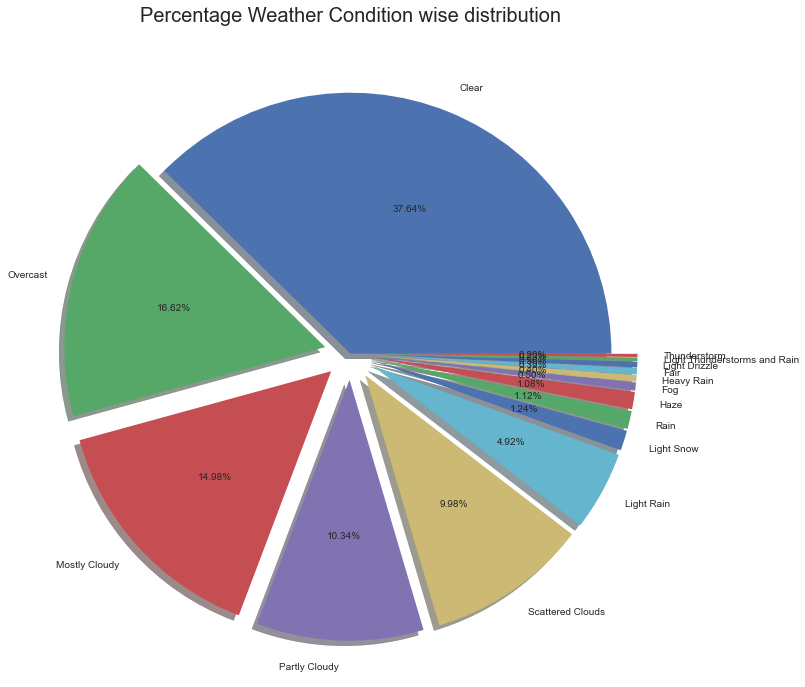

In [45]:
data_weath = df_17.Weather_Condition.value_counts().reset_index().rename(columns={
    'index':'Weather_Condition',
    'Weather_Condition' : 'Weather_Counts'
}).head(15)
fig = plt.figure(figsize=(14,12))
sns.barplot(x = 'Weather_Counts',y = 'Weather_Condition',data=data_weath)
plt.title("Top 15 Weather conditions on days of accidents",fontsize=20)
plt.xlabel("Weather Count",fontsize=30)
plt.ylabel("Weather Type",fontsize=30)
plt.show()
lst = [0.1]*15
lst[0] = 0
fig = plt.figure(figsize=(14,12))
plt.pie(data_weath.Weather_Counts,labels=data_weath.Weather_Condition,
        shadow=True,autopct='%1.2f%%',explode=lst)
plt.title('Percentage Weather Condition wise distribution',fontsize=20)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.show()

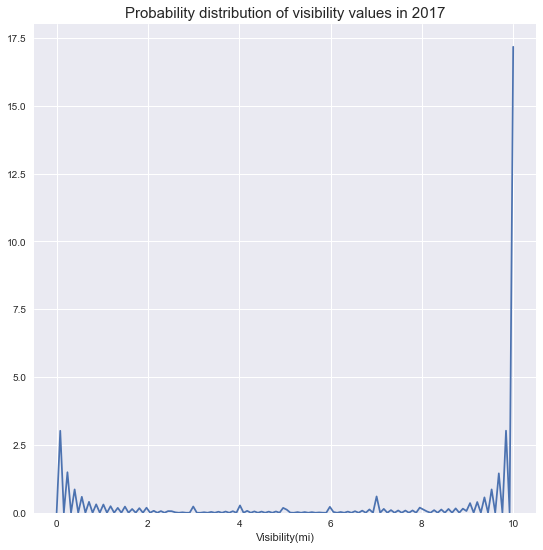

In [46]:
df_vis = df_17[df_17['Visibility(mi)'] <= 10 ]
fig = plt.figure(figsize=(9,9))
sns.distplot(df_vis['Visibility(mi)'],hist=False)
plt.title("Probability distribution of visibility values in 2017",
         fontsize=15)
plt.show()